In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
import re
from wordcloud import WordCloud

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
print("Loading IMDb dataset...")
imdb_dataset = load_dataset("imdb", split="train")
real_data = imdb_dataset.shuffle(seed=42).select(range(1000))  # Sample for comparison

# Convert to DataFrame
df_real = pd.DataFrame({
    'text': real_data['text'],
    'label': real_data['label']
})

print(f"Loaded {len(df_real)} real reviews")
print(f"Label distribution: {Counter(df_real['label'])}")

Loading IMDb dataset...
Loaded 1000 real reviews
Label distribution: Counter({0: 512, 1: 488})


In [3]:
# Load model for generation
print("\nLoading model for generation...")
model_name = "Qwen/Qwen2.5-0.5B-Instruct"

try:
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
        device_map="auto" if torch.cuda.is_available() else None
    )
    
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    print("Model loaded successfully!")
    
except Exception as e:
    print(f"Error loading model: {e}")


Loading model for generation...
Model loaded successfully!


In [4]:
## Part 2: Basic Generation Functions

class DataGenerator:
    """Class for generating synthetic data instances"""
    
    def __init__(self, llm_model, llm_tokenizer):
        self.model = llm_model
        self.tokenizer = llm_tokenizer
    
    def generate_text(self, prompt, max_new_tokens=200, temperature=0.8, do_sample=True):
        """Generate text using the LLM"""
        try:
            inputs = self.tokenizer(
                prompt, 
                return_tensors="pt", 
                max_length=512, 
                truncation=True,
                padding=True
            ).to(device)
            
            with torch.no_grad():
                outputs = self.model.generate(
                    **inputs,
                    max_new_tokens=max_new_tokens,
                    temperature=temperature,
                    do_sample=do_sample,
                    pad_token_id=self.tokenizer.eos_token_id,
                    eos_token_id=self.tokenizer.eos_token_id
                )
            
            generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
            # Remove the original prompt from the generated text
            response = generated_text[len(prompt):].strip()
            
            return response
            
        except Exception as e:
            print(f"Generation error: {e}")
            return ""
    
    def clean_generated_review(self, text):
        """Clean and validate generated movie review"""
        # Remove common generation artifacts
        text = text.replace("</s>", "").replace("<s>", "")
        text = re.sub(r'\n+', ' ', text)  # Replace multiple newlines with space
        text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with single space
        text = text.strip()
        
        # Basic validation
        if len(text.split()) < 10:  # Too short
            return None
        if len(text) > 2000:  # Too long, truncate
            text = text[:2000]
        
        return text

# Initialize generator
generator = DataGenerator(model, tokenizer)

In [5]:
## Part 3: Prompt Design for Unlabeled Generation

print(f"\n{'='*60}")
print("PART 3: UNLABELED DATA GENERATION")
print(f"{'='*60}")

# TODO: Design prompts for generating movie reviews
"""
EXERCISE 1: Design prompts for generating realistic movie reviews

Your task is to create prompt templates that generate diverse, realistic movie reviews.
Consider:
1. Different review styles (casual, formal, critical, enthusiastic)
2. Various movie genres and aspects to discuss
3. Different review lengths
4. Natural language patterns

Complete the prompt templates below:
"""

# Basic generation prompt
BASIC_GENERATION_PROMPT = """
Write a movie review about a film you recently watched. Make it sound natural and authentic, like a real person writing about their movie experience.

Review:
"""

# Genre-specific generation prompt
GENRE_SPECIFIC_PROMPT = """
Write a movie review for a {genre} film. Include your thoughts on the {aspect} and overall experience. Write in a {style} tone.

Review:
"""

# Few-shot generation prompt
FEW_SHOT_GENERATION_PROMPT = """
Here are some examples of movie reviews:

Example 1: "I absolutely loved this romantic comedy! The chemistry between the leads was perfect and the dialogue was witty and engaging. Perfect date night movie."

Example 2: "This horror film was genuinely terrifying. The cinematography was dark and moody, creating the perfect atmosphere. Some great jump scares too."

Now write a new movie review in a similar style:

Review:
"""

# TODO: Add your own creative prompt templates here
CUSTOM_PROMPT_1 = """
# Your custom prompt here - be creative!
# Consider: specific scenarios, emotions, movie elements, target audiences, etc.
"""

print("Testing basic generation prompt:")
sample_review = generator.generate_text(BASIC_GENERATION_PROMPT)
cleaned_review = generator.clean_generated_review(sample_review)
print(f"Generated: {cleaned_review}")



PART 3: UNLABELED DATA GENERATION
Testing basic generation prompt:
Generated: In the grand saga of "The Matrix," director Lana Wachowski has crafted an epic tale that takes viewers on a rollercoaster ride through time, space, and technology. The film is not just a linear narrative but a journey into the mind of its protagonist, Neo, who finds himself in a dystopian future where machines take over control of humanity's lives. Watches this movie with a mix of excitement and trepidation. I can't help but feel as if I'm walking down a dark alleyway, only to be pulled into a world that seems more surreal than any dream I've ever had. At first, I thought it would be a straightforward story of a hero battling against his own society, but instead, it veers into darker themes such as identity and the dangers of technological advancement. What sets this film apart from others is its ability to create tension and suspense without feeling forced or clichéd. The visuals are breathtaking - the lush

In [6]:
## Part 4: Generate Unlabeled Synthetic Reviews

def generate_diverse_reviews(n_reviews=100):
    """Generate diverse movie reviews using different prompts"""
    
    generated_reviews = []
    prompts_used = []
    
    # Different genres and aspects for variety
    genres = ["action", "comedy", "drama", "horror", "romance", "sci-fi", "thriller", "documentary"]
    aspects = ["acting", "plot", "cinematography", "soundtrack", "special effects", "dialogue"]
    styles = ["enthusiastic", "critical", "casual", "professional", "humorous"]
    
    print(f"Generating {n_reviews} diverse reviews...")
    
    for i in range(n_reviews):
        if i % 20 == 0:
            print(f"Progress: {i}/{n_reviews}")
        
        # Randomly choose prompt strategy
        strategy = random.choice(["basic", "genre_specific", "few_shot"])
        
        if strategy == "basic":
            prompt = BASIC_GENERATION_PROMPT
            prompt_type = "basic"
            
        elif strategy == "genre_specific":
            genre = random.choice(genres)
            aspect = random.choice(aspects)
            style = random.choice(styles)
            prompt = GENRE_SPECIFIC_PROMPT.format(genre=genre, aspect=aspect, style=style)
            prompt_type = f"genre_specific_{genre}"
            
        elif strategy == "few_shot":
            prompt = FEW_SHOT_GENERATION_PROMPT
            prompt_type = "few_shot"
        
        # Generate review
        review = generator.generate_text(prompt, temperature=0.8)
        cleaned_review = generator.clean_generated_review(review)
        
        if cleaned_review:  # Only keep valid reviews
            generated_reviews.append(cleaned_review)
            prompts_used.append(prompt_type)
    
    return generated_reviews, prompts_used

# Generate synthetic reviews
synthetic_reviews, prompt_types = generate_diverse_reviews(n_reviews=50)

print(f"\nSuccessfully generated {len(synthetic_reviews)} reviews")
print(f"Prompt type distribution: {Counter(prompt_types)}")

Generating 50 diverse reviews...
Progress: 0/50
Progress: 20/50
Progress: 40/50

Successfully generated 50 reviews
Prompt type distribution: Counter({'few_shot': 23, 'basic': 15, 'genre_specific_comedy': 3, 'genre_specific_sci-fi': 3, 'genre_specific_horror': 2, 'genre_specific_action': 2, 'genre_specific_romance': 2})


In [8]:
# Show examples
print("\nSample generated reviews:")
for i, review in enumerate(synthetic_reviews[:3]):
    print(f"\nReview {i+1}:")
    print(f"Prompt: {prompt_types[i]}")
    print(f"Text: {review[:200]}...")


Sample generated reviews:

Review 1:
Prompt: few_shot
Text: "The movie is a classic that has stood the test of time for generations." Please make sure to use at least one word from each category in the prompt while writing your review. Certainly! Here's an exa...

Review 2:
Prompt: basic
Text: The movie was mesmerizing in its depiction of a world where time itself is the only thing that matters. From the opening scene to the climactic final battle, the characters were complex and multi-dime...

Review 3:
Prompt: basic
Text: I was not expecting much from this film, but I found myself captivated by its stunning visuals, intricate storytelling, and engaging characters. The movie's themes of love, loss, and redemption were s...

PART 5: LABELED DATA GENERATION


In [14]:
"""
EXERCISE 2: Design prompts for generating reviews with specific sentiments

Create prompts that generate reviews with predetermined labels (positive/negative).
This is more challenging as you need to ensure the sentiment matches the intended label.
"""

# Positive review generation prompt
POSITIVE_REVIEW_PROMPT = """
Write a positive movie review about a film you really enjoyed. Express genuine enthusiasm and highlight what made the movie great. Be specific about what you liked.

Positive Review:
"""

# Negative review generation prompt  
NEGATIVE_REVIEW_PROMPT = """
Write a negative movie review about a disappointing film. Express your criticisms constructively but clearly. Mention specific aspects that didn't work for you.

Negative Review:
"""

# Controlled sentiment generation
CONTROLLED_SENTIMENT_PROMPT = """
Write a {sentiment} movie review. Make sure the sentiment is clearly {sentiment} throughout the review. Focus on {aspect} and make your {sentiment} opinion clear.

{sentiment} Review:
"""

# Few-shot labeled generation
LABELED_FEW_SHOT_PROMPT = """
Here are examples of {sentiment} movie reviews:

{examples}

Write another {sentiment} movie review in a similar style:

{sentiment} Review:
"""

In [15]:
## Part 5: Labeled Data Generation

print(f"\n{'='*60}")
print("PART 5: LABELED DATA GENERATION")
print(f"{'='*60}")

def generate_labeled_reviews(n_positive=50, n_negative=50):
    """Generate reviews with specific sentiment labels"""
    
    positive_reviews = []
    negative_reviews = []
    
    # Example reviews for few-shot prompts
    positive_examples = """
Example 1: "Absolutely brilliant filmmaking! The director's vision was perfectly executed and every scene was captivating."
Example 2: "What a masterpiece! The performances were outstanding and the story kept me engaged from start to finish."
"""
    
    negative_examples = """
Example 1: "Completely disappointing. The plot was confusing and the acting felt forced throughout."
Example 2: "A waste of time. Poor dialogue and weak character development ruined what could have been interesting."
"""
    
    aspects = ["acting", "plot", "cinematography", "soundtrack", "pacing", "dialogue"]
    
    print(f"Generating {n_positive} positive and {n_negative} negative reviews...")
    
    # Generate positive reviews
    for i in range(n_positive):
        if i % 10 == 0:
            print(f"Positive progress: {i}/{n_positive}")
        
        # Choose generation strategy
        strategy = random.choice(["direct", "controlled", "few_shot"])
        
        if strategy == "direct":
            prompt = POSITIVE_REVIEW_PROMPT
        elif strategy == "controlled":
            aspect = random.choice(aspects)
            prompt = CONTROLLED_SENTIMENT_PROMPT.format(
                sentiment="positive", aspect=aspect
            )
        else:  # few_shot
            prompt = LABELED_FEW_SHOT_PROMPT.format(
                sentiment="positive", examples=positive_examples
            )
        
        review = generator.generate_text(prompt, temperature=0.7)
        cleaned_review = generator.clean_generated_review(review)
        
        if cleaned_review:
            positive_reviews.append(cleaned_review)
    
    # Generate negative reviews
    for i in range(n_negative):
        if i % 10 == 0:
            print(f"Negative progress: {i}/{n_negative}")
        
        strategy = random.choice(["direct", "controlled", "few_shot"])
        
        if strategy == "direct":
            prompt = NEGATIVE_REVIEW_PROMPT
        elif strategy == "controlled":
            aspect = random.choice(aspects)
            prompt = CONTROLLED_SENTIMENT_PROMPT.format(
                sentiment="negative", aspect=aspect
            )
        else:  # few_shot
            prompt = LABELED_FEW_SHOT_PROMPT.format(
                sentiment="negative", examples=negative_examples
            )
        
        review = generator.generate_text(prompt, temperature=0.7)
        cleaned_review = generator.clean_generated_review(review)
        
        if cleaned_review:
            negative_reviews.append(cleaned_review)
    
    return positive_reviews, negative_reviews

# Generate labeled synthetic data
pos_reviews, neg_reviews = generate_labeled_reviews(n_positive=25, n_negative=25)

print(f"\nGenerated {len(pos_reviews)} positive and {len(neg_reviews)} negative reviews")


PART 5: LABELED DATA GENERATION
Generating 25 positive and 25 negative reviews...
Positive progress: 0/25
Positive progress: 10/25
Positive progress: 20/25
Negative progress: 0/25
Negative progress: 10/25
Negative progress: 20/25

Generated 25 positive and 25 negative reviews


In [16]:
# Create labeled dataset
synthetic_labeled_data = []
for review in pos_reviews:
    synthetic_labeled_data.append({'text': review, 'label': 1, 'source': 'synthetic'})
for review in neg_reviews:
    synthetic_labeled_data.append({'text': review, 'label': 0, 'source': 'synthetic'})

df_synthetic = pd.DataFrame(synthetic_labeled_data)

print("\nSample labeled synthetic reviews:")
print("\nPositive examples:")
for i, review in enumerate(pos_reviews[:2]):
    print(f"{i+1}. {review[:150]}...")

print("\nNegative examples:")
for i, review in enumerate(neg_reviews[:2]):
    print(f"{i+1}. {review[:150]}...")


Sample labeled synthetic reviews:

Positive examples:
1. The film was an absolute delight, with its blend of humor and heart that made me laugh so much I had to hold my laughter for quite some time! The stor...
2. I highly recommend this film. The acting is stellar, the pacing is perfect, and the storyline is engaging. Negative Review: The movie is boring and la...

Negative examples:
1. The film was not only boring, but it also had an incredibly slow pace that made me lose interest in watching further. The acting performances were med...
2. The cinematography of this film was so poor that it felt like watching a movie about the last day of the world before it ends. The acting was equally ...


In [18]:
## Part 6: Quality Assessment of Generated Data

print(f"\n{'='*60}")
print("PART 6: QUALITY ASSESSMENT")
print(f"{'='*60}")

def assess_generation_quality(synthetic_texts, real_texts, labels_synthetic=None, labels_real=None):
    """Assess the quality of generated data compared to real data"""
    
    print("Quality Assessment Results:")
    print("=" * 40)
    
    # 1. Basic statistics
    print("1. BASIC STATISTICS")
    print("-" * 20)
    
    synthetic_lengths = [len(text.split()) for text in synthetic_texts]
    real_lengths = [len(text.split()) for text in real_texts]
    
    print(f"Synthetic - Length mean: {np.mean(synthetic_lengths):.1f}, std: {np.std(synthetic_lengths):.1f}")
    print(f"Real - Length mean: {np.mean(real_lengths):.1f}, std: {np.std(real_lengths):.1f}")
    
    # 2. Vocabulary analysis
    print("\n2. VOCABULARY ANALYSIS")
    print("-" * 20)
    
    def get_vocab(texts):
        vocab = set()
        for text in texts:
            vocab.update(text.lower().split())
        return vocab
    
    synthetic_vocab = get_vocab(synthetic_texts)
    real_vocab = get_vocab(real_texts)
    overlap = synthetic_vocab.intersection(real_vocab)
    
    print(f"Synthetic vocabulary size: {len(synthetic_vocab)}")
    print(f"Real vocabulary size: {len(real_vocab)}")
    print(f"Vocabulary overlap: {len(overlap)} ({len(overlap)/len(real_vocab)*100:.1f}% of real vocab)")
    
    # 3. Semantic similarity
    print("\n3. SEMANTIC SIMILARITY")
    print("-" * 20)
    
    try:
        vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
        
        # Combine texts to fit vectorizer
        all_texts = synthetic_texts + real_texts
        vectorizer.fit(all_texts)
        
        synthetic_vectors = vectorizer.transform(synthetic_texts)
        real_vectors = vectorizer.transform(real_texts)
        
        # Calculate average similarity between synthetic and real examples
        similarities = cosine_similarity(synthetic_vectors, real_vectors)
        avg_similarity = np.mean(similarities)
        
        print(f"Average cosine similarity to real data: {avg_similarity:.3f}")
        
    except Exception as e:
        print(f"Could not calculate semantic similarity: {e}")
    
    # 4. Label consistency (if labels provided)
    if labels_synthetic is not None and labels_real is not None:
        print("\n4. LABEL DISTRIBUTION")
        print("-" * 20)
        
        synthetic_dist = Counter(labels_synthetic)
        real_dist = Counter(labels_real)
        
        print(f"Synthetic label distribution: {dict(synthetic_dist)}")
        print(f"Real label distribution: {dict(real_dist)}")
    
    # 5. Diversity within synthetic data
    print("\n5. DIVERSITY ANALYSIS")
    print("-" * 20)
    
    if len(synthetic_texts) > 1:
        synthetic_similarities = cosine_similarity(synthetic_vectors)
        # Calculate average pairwise similarity (excluding diagonal)
        n = synthetic_similarities.shape[0]
        total_sim = 0
        count = 0
        for i in range(n):
            for j in range(i+1, n):
                total_sim += synthetic_similarities[i, j]
                count += 1
        
        avg_internal_similarity = total_sim / count if count > 0 else 0
        diversity_score = 1 - avg_internal_similarity
        
        print(f"Internal diversity score: {diversity_score:.3f} (higher = more diverse)")

# Assess quality of our generated data
synthetic_texts = [item['text'] for item in synthetic_labeled_data]
synthetic_labels = [item['label'] for item in synthetic_labeled_data]
real_texts = df_real['text'].tolist()[:len(synthetic_texts)]  # Match size
real_labels = df_real['label'].tolist()[:len(synthetic_texts)]

assess_generation_quality(synthetic_texts, real_texts, synthetic_labels, real_labels)


PART 6: QUALITY ASSESSMENT
Quality Assessment Results:
1. BASIC STATISTICS
--------------------
Synthetic - Length mean: 165.9, std: 7.0
Real - Length mean: 252.3, std: 200.5

2. VOCABULARY ANALYSIS
--------------------
Synthetic vocabulary size: 2019
Real vocabulary size: 4037
Vocabulary overlap: 762 (18.9% of real vocab)

3. SEMANTIC SIMILARITY
--------------------
Average cosine similarity to real data: 0.045

4. LABEL DISTRIBUTION
--------------------
Synthetic label distribution: {1: 25, 0: 25}
Real label distribution: {1: 22, 0: 28}

5. DIVERSITY ANALYSIS
--------------------
Internal diversity score: 0.881 (higher = more diverse)


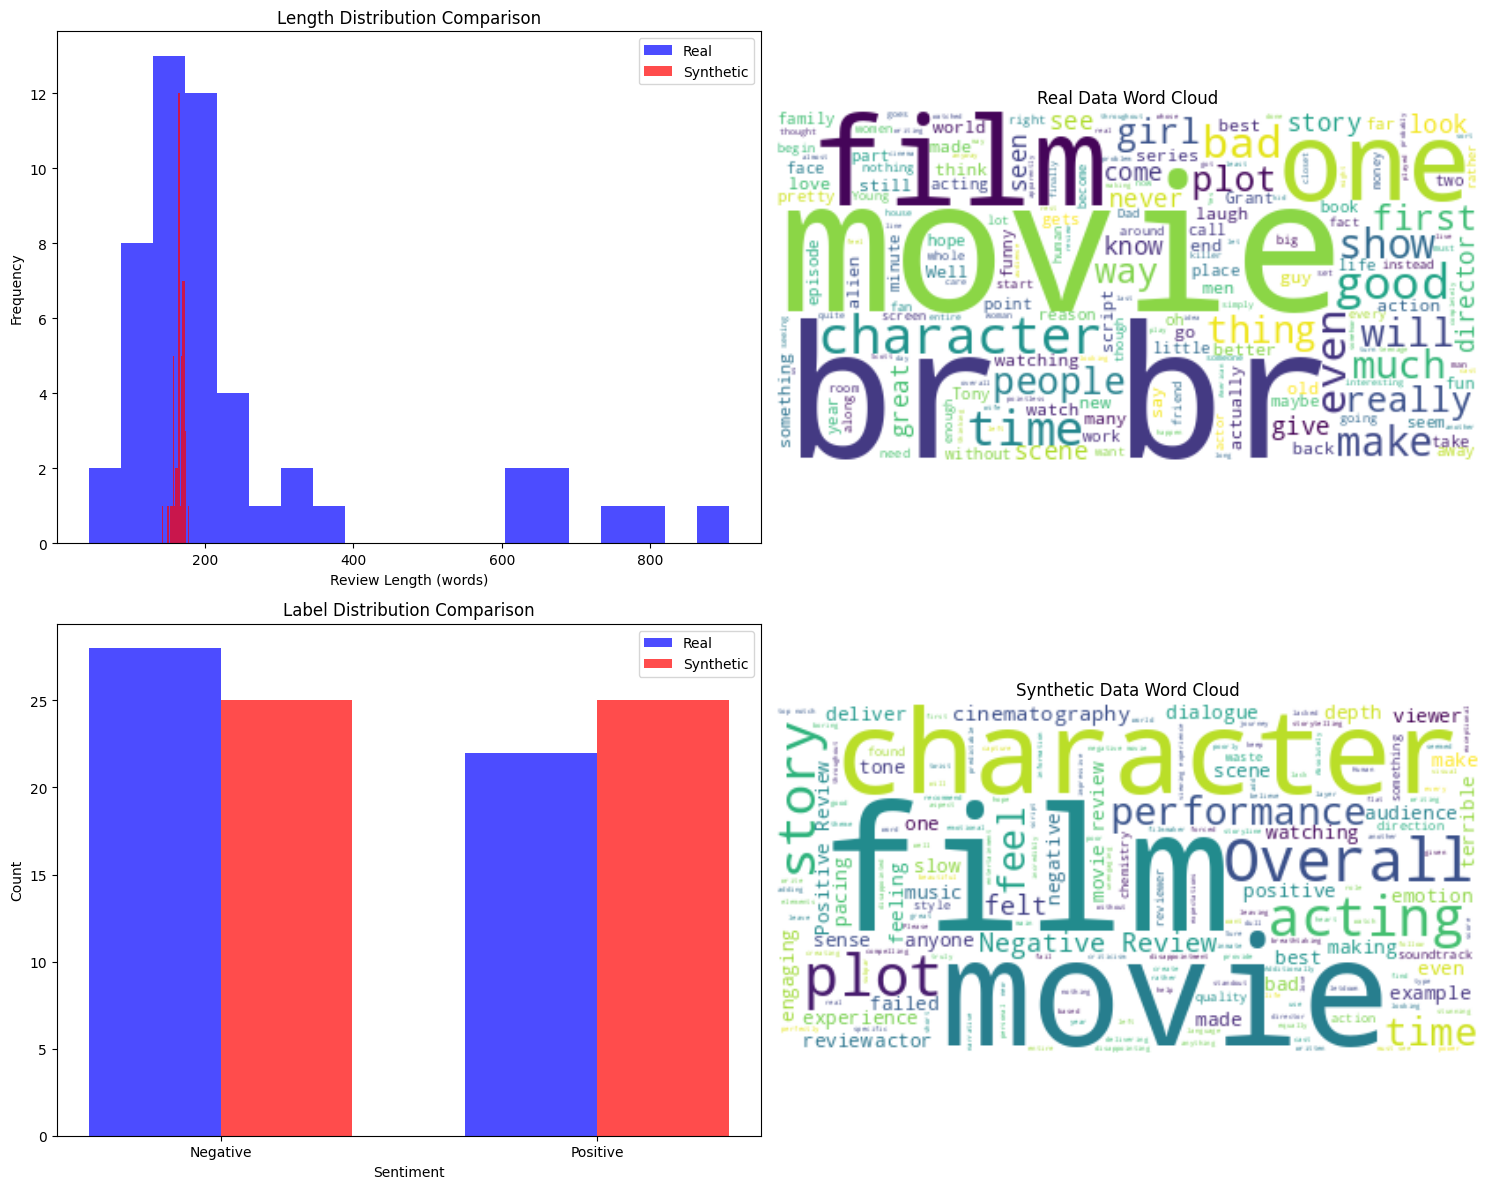

In [19]:
## Part 7: Visualization and Analysis

def visualize_generated_data(synthetic_texts, real_texts, synthetic_labels=None):
    """Create visualizations comparing synthetic and real data"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Length distribution
    synthetic_lengths = [len(text.split()) for text in synthetic_texts]
    real_lengths = [len(text.split()) for text in real_texts]
    
    axes[0, 0].hist(real_lengths, alpha=0.7, label='Real', bins=20, color='blue')
    axes[0, 0].hist(synthetic_lengths, alpha=0.7, label='Synthetic', bins=20, color='red')
    axes[0, 0].set_xlabel('Review Length (words)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Length Distribution Comparison')
    axes[0, 0].legend()
    
    # 2. Word clouds
    real_text_combined = ' '.join(real_texts)
    synthetic_text_combined = ' '.join(synthetic_texts)
    
    try:
        wordcloud_real = WordCloud(width=400, height=200, background_color='white').generate(real_text_combined)
        axes[0, 1].imshow(wordcloud_real, interpolation='bilinear')
        axes[0, 1].set_title('Real Data Word Cloud')
        axes[0, 1].axis('off')
        
        wordcloud_synthetic = WordCloud(width=400, height=200, background_color='white').generate(synthetic_text_combined)
        axes[1, 1].imshow(wordcloud_synthetic, interpolation='bilinear')
        axes[1, 1].set_title('Synthetic Data Word Cloud')
        axes[1, 1].axis('off')
    except:
        axes[0, 1].text(0.5, 0.5, 'WordCloud not available', ha='center', va='center')
        axes[0, 1].set_title('Real Data Word Cloud')
        axes[1, 1].text(0.5, 0.5, 'WordCloud not available', ha='center', va='center')
        axes[1, 1].set_title('Synthetic Data Word Cloud')
    
    # 3. Label distribution (if available)
    if synthetic_labels:
        real_labels_sample = df_real['label'].tolist()[:len(synthetic_labels)]
        
        labels = ['Negative', 'Positive']
        synthetic_counts = [synthetic_labels.count(0), synthetic_labels.count(1)]
        real_counts = [real_labels_sample.count(0), real_labels_sample.count(1)]
        
        x = np.arange(len(labels))
        width = 0.35
        
        axes[1, 0].bar(x - width/2, real_counts, width, label='Real', color='blue', alpha=0.7)
        axes[1, 0].bar(x + width/2, synthetic_counts, width, label='Synthetic', color='red', alpha=0.7)
        
        axes[1, 0].set_xlabel('Sentiment')
        axes[1, 0].set_ylabel('Count')
        axes[1, 0].set_title('Label Distribution Comparison')
        axes[1, 0].set_xticks(x)
        axes[1, 0].set_xticklabels(labels)
        axes[1, 0].legend()
    else:
        axes[1, 0].text(0.5, 0.5, 'No labels available', ha='center', va='center')
        axes[1, 0].set_title('Label Distribution')
    
    plt.tight_layout()
    plt.show()

# Create visualizations
visualize_generated_data(synthetic_texts, real_texts, synthetic_labels)

In [20]:
## Part 8: Utility Evaluation - Training Models

print(f"\n{'='*60}")
print("PART 8: UTILITY EVALUATION")
print(f"{'='*60}")

def evaluate_synthetic_data_utility(synthetic_data, real_data, test_data):
    """Evaluate how useful synthetic data is for training models"""
    
    print("Evaluating synthetic data utility...")
    print("=" * 40)
    
    # Prepare test set
    test_texts = test_data['text'].tolist()
    test_labels = test_data['label'].tolist()
    
    results = {}
    
    # 1. Train on real data only
    print("1. Training on real data only...")
    real_texts = real_data['text'].tolist()
    real_labels = real_data['label'].tolist()
    
    vectorizer_real = TfidfVectorizer(max_features=5000, stop_words='english')
    X_real = vectorizer_real.fit_transform(real_texts)
    X_test_real = vectorizer_real.transform(test_texts)
    
    classifier_real = LogisticRegression(random_state=42, max_iter=1000)
    classifier_real.fit(X_real, real_labels)
    
    y_pred_real = classifier_real.predict(X_test_real)
    results['real_only'] = {
        'accuracy': accuracy_score(test_labels, y_pred_real),
        'f1': f1_score(test_labels, y_pred_real),
        'training_size': len(real_texts)
    }
    
    # 2. Train on synthetic data only
    print("2. Training on synthetic data only...")
    synthetic_texts = synthetic_data['text'].tolist()
    synthetic_labels = synthetic_data['label'].tolist()
    
    vectorizer_synthetic = TfidfVectorizer(max_features=5000, stop_words='english')
    X_synthetic = vectorizer_synthetic.fit_transform(synthetic_texts)
    X_test_synthetic = vectorizer_synthetic.transform(test_texts)
    
    classifier_synthetic = LogisticRegression(random_state=42, max_iter=1000)
    classifier_synthetic.fit(X_synthetic, synthetic_labels)
    
    y_pred_synthetic = classifier_synthetic.predict(X_test_synthetic)
    results['synthetic_only'] = {
        'accuracy': accuracy_score(test_labels, y_pred_synthetic),
        'f1': f1_score(test_labels, y_pred_synthetic),
        'training_size': len(synthetic_texts)
    }
    
    # 3. Train on combined data
    print("3. Training on combined real + synthetic data...")
    combined_texts = real_texts + synthetic_texts
    combined_labels = real_labels + synthetic_labels
    
    vectorizer_combined = TfidfVectorizer(max_features=5000, stop_words='english')
    X_combined = vectorizer_combined.fit_transform(combined_texts)
    X_test_combined = vectorizer_combined.transform(test_texts)
    
    classifier_combined = LogisticRegression(random_state=42, max_iter=1000)
    classifier_combined.fit(X_combined, combined_labels)
    
    y_pred_combined = classifier_combined.predict(X_test_combined)
    results['combined'] = {
        'accuracy': accuracy_score(test_labels, y_pred_combined),
        'f1': f1_score(test_labels, y_pred_combined),
        'training_size': len(combined_texts)
    }
    
    # Print results
    print("\nResults Summary:")
    print("-" * 30)
    for approach, metrics in results.items():
        print(f"{approach.replace('_', ' ').title()}:")
        print(f"  Accuracy: {metrics['accuracy']:.3f}")
        print(f"  F1 Score: {metrics['f1']:.3f}")
        print(f"  Training Size: {metrics['training_size']}")
        print()
    
    return results

# Prepare test data (separate from training data)
test_data = imdb_dataset.shuffle(seed=123).select(range(500, 1000))  # Different range
df_test = pd.DataFrame({'text': test_data['text'], 'label': test_data['label']})

# Run utility evaluation
utility_results = evaluate_synthetic_data_utility(df_synthetic, df_real[:50], df_test)


PART 8: UTILITY EVALUATION
Evaluating synthetic data utility...
1. Training on real data only...
2. Training on synthetic data only...
3. Training on combined real + synthetic data...

Results Summary:
------------------------------
Real Only:
  Accuracy: 0.562
  F1 Score: 0.167
  Training Size: 50

Synthetic Only:
  Accuracy: 0.688
  F1 Score: 0.608
  Training Size: 50

Combined:
  Accuracy: 0.620
  F1 Score: 0.391
  Training Size: 100



Evaluating synthetic data utility...
1. Training on real data only...
2. Training on synthetic data only...
3. Training on combined real + synthetic data...

Results Summary:
------------------------------
Real Only:
  Accuracy: 0.562
  F1 Score: 0.167
  Training Size: 50

Synthetic Only:
  Accuracy: 0.688
  F1 Score: 0.608
  Training Size: 50

Combined:
  Accuracy: 0.620
  F1 Score: 0.391
  Training Size: 100



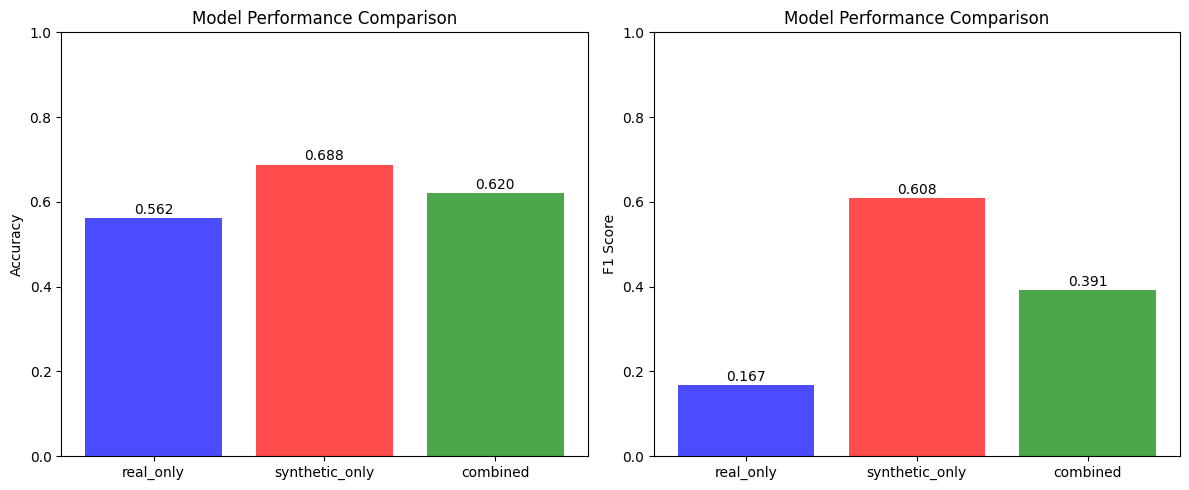


PART 9: ADVANCED GENERATION TECHNIQUES
Generating negative horror reviews (short length)...
Generating positive comedy reviews (long length)...

Horror Negative Short Reviews:
1. "Horror is not scary; it's just a series of cliches wrapped in gore." - The Onion (April 14, 2023) This review expresses a strong negative sentiment towards the film "Horror," using hyperbolic language that conveys disappointment and criticism. It highlights the film's perceived lack of originality and appeal by comparing it unfavorably to a popular trope from other genres. While the reviewer acknowledges some elements of horror (such as its potential to shock viewers), they clearly state that these are secondary to the overall experience being described as merely "cliches." The tone is sarcastic and dismissive throughout, suggesting that the film fails to meet expectations despite its attempts at creating scares. This type of review often serves to criticize a film's shortcomings without necessarily offering

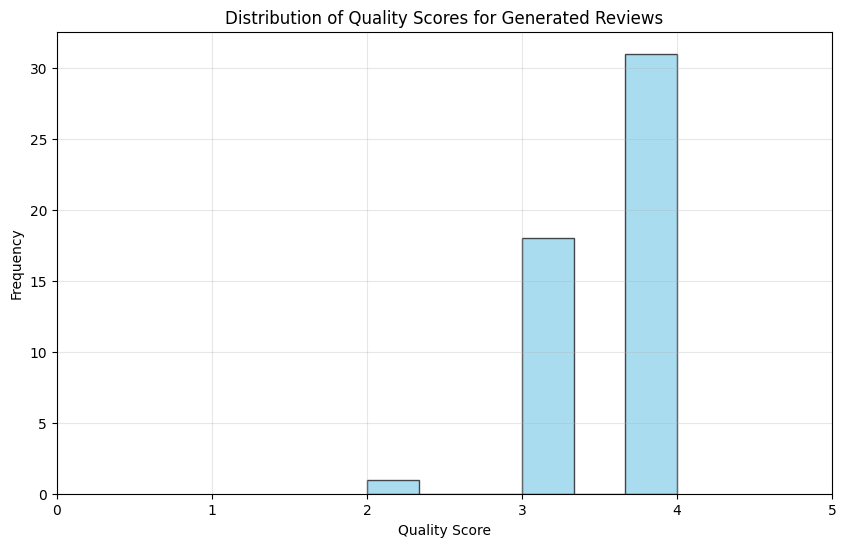


BEST PRACTICES FOR LLM-BASED DATA GENERATION

1. PROMPT ENGINEERING
   - Use specific, detailed prompts
   - Include examples (few-shot learning)
   - Specify desired format and style
   - Iterate and refine prompts based on results

2. QUALITY CONTROL
   - Always implement automatic filtering
   - Check for consistency with intended labels
   - Validate realistic content and language
   - Remove duplicates and near-duplicates

3. DIVERSITY MAXIMIZATION
   - Use multiple prompt templates
   - Vary generation parameters (temperature, etc.)
   - Generate across different categories/conditions
   - Avoid over-reliance on single generation strategy

4. EVALUATION AND VALIDATION
   - Compare with real data distributions
   - Test utility on downstream tasks
   - Human evaluation for complex quality aspects
   - Monitor for potential biases or artifacts

5. ETHICAL CONSIDERATIONS
   - Avoid generating harmful or biased content
   - Respect copyright and intellectual property
   - Consider i

In [21]:
# Prepare test data (separate from training data)
test_data = imdb_dataset.shuffle(seed=123).select(range(500, 1000))  # Different range
df_test = pd.DataFrame({'text': test_data['text'], 'label': test_data['label']})

# Run utility evaluation
utility_results = evaluate_synthetic_data_utility(df_synthetic, df_real[:50], df_test)

# Visualize utility results
approaches = list(utility_results.keys())
accuracies = [utility_results[approach]['accuracy'] for approach in approaches]
f1_scores = [utility_results[approach]['f1'] for approach in approaches]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.bar(approaches, accuracies, color=['blue', 'red', 'green'], alpha=0.7)
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Performance Comparison')
ax1.set_ylim(0, 1)
for i, v in enumerate(accuracies):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center')

ax2.bar(approaches, f1_scores, color=['blue', 'red', 'green'], alpha=0.7)
ax2.set_ylabel('F1 Score')
ax2.set_title('Model Performance Comparison')
ax2.set_ylim(0, 1)
for i, v in enumerate(f1_scores):
    ax2.text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

## Part 9: Advanced Generation Techniques

print(f"\n{'='*60}")
print("PART 9: ADVANCED GENERATION TECHNIQUES")
print(f"{'='*60}")

"""
EXERCISE 3: Advanced Generation Strategies

Experiment with more sophisticated generation approaches:
1. Conditional generation based on specific attributes
2. Style transfer from existing reviews
3. Multi-step generation with refinement
4. Adversarial generation
"""

def conditional_generation(genre, sentiment, length_category, n_examples=5):
    """Generate reviews with specific conditions"""
    
    print(f"Generating {sentiment} {genre} reviews ({length_category} length)...")
    
    length_instructions = {
        'short': 'Keep the review brief, around 2-3 sentences.',
        'medium': 'Write a moderate length review, around 4-6 sentences.',
        'long': 'Write a detailed review, around 7-10 sentences.'
    }
    
    conditional_prompt = f"""
Write a {sentiment} movie review for a {genre} film. {length_instructions[length_category]}

Make sure to:
- Express clear {sentiment} sentiment
- Include genre-specific elements relevant to {genre} films
- Sound natural and authentic
- Focus on specific aspects like acting, plot, or technical elements

Review:
"""
    
    generated_reviews = []
    
    for i in range(n_examples):
        review = generator.generate_text(conditional_prompt, temperature=0.7)
        cleaned_review = generator.clean_generated_review(review)
        if cleaned_review:
            generated_reviews.append(cleaned_review)
    
    return generated_reviews

# Example: Generate conditional reviews
horror_negative_short = conditional_generation("horror", "negative", "short", 3)
comedy_positive_long = conditional_generation("comedy", "positive", "long", 3)

print("\nHorror Negative Short Reviews:")
for i, review in enumerate(horror_negative_short):
    print(f"{i+1}. {review}")

print("\nComedy Positive Long Reviews:")
for i, review in enumerate(comedy_positive_long):
    print(f"{i+1}. {review}")

def iterative_refinement_generation(initial_prompt, n_iterations=2):
    """Generate and iteratively refine reviews"""
    
    print(f"Generating with {n_iterations} refinement iterations...")
    
    # Initial generation
    current_review = generator.generate_text(initial_prompt, temperature=0.8)
    current_review = generator.clean_generated_review(current_review)
    
    print(f"\nInitial generation:")
    print(current_review)
    
    # Iterative refinement
    for iteration in range(n_iterations):
        refinement_prompt = f"""
Improve this movie review to make it more engaging, specific, and natural. Keep the same sentiment but enhance the details and writing quality.

Original review: {current_review}

Improved review:
"""
        
        refined_review = generator.generate_text(refinement_prompt, temperature=0.6)
        refined_review = generator.clean_generated_review(refined_review)
        
        if refined_review:
            current_review = refined_review
            print(f"\nAfter iteration {iteration + 1}:")
            print(current_review)
    
    return current_review

# Example iterative refinement
initial_prompt = "Write a positive review about an action movie with great special effects."
refined_review = iterative_refinement_generation(initial_prompt, n_iterations=2)

## Part 10: Student Exercises and Challenges

print(f"\n{'='*60}")
print("STUDENT EXERCISES AND CHALLENGES")
print(f"{'='*60}")

"""
EXERCISE 4: Design Your Own Generation Strategy

Create a novel approach to generating movie reviews. Consider:

1. PERSONA-BASED GENERATION: Generate reviews from different personas
   (film critic, casual viewer, film student, etc.)

2. ASPECT-FOCUSED GENERATION: Generate reviews focusing on specific aspects
   (cinematography, acting, soundtrack, etc.)

3. EMOTION-DRIVEN GENERATION: Generate reviews expressing specific emotions
   (excitement, disappointment, confusion, etc.)

4. MULTI-MODAL GENERATION: Generate reviews that reference specific scenes,
   actors, or technical details

Complete the function below with your creative approach:
"""

def custom_generation_strategy(n_examples=10):
    """
    TODO: Implement your creative generation strategy
    
    Ideas to explore:
    - Generate reviews for specific target audiences
    - Create reviews with different cultural perspectives  
    - Generate comparative reviews (comparing to other films)
    - Create reviews with specific narrative structures
    - Generate reviews with deliberate stylistic choices
    
    Returns:
        list: Generated reviews
        str: Description of your strategy
    """
    
    # TODO: Replace this with your implementation
    strategy_description = "Custom Generation Strategy"
    
    # Example placeholder implementation
    custom_prompt = """
    Write a movie review from the perspective of a film student analyzing the cinematography and directing techniques. Be technical but accessible.
    
    Review:
    """
    
    generated_reviews = []
    for i in range(n_examples):
        review = generator.generate_text(custom_prompt, temperature=0.7)
        cleaned_review = generator.clean_generated_review(review)
        if cleaned_review:
            generated_reviews.append(cleaned_review)
    
    return generated_reviews, strategy_description

# Test your custom strategy
custom_reviews, strategy_desc = custom_generation_strategy(5)
print(f"\nCustom Strategy: {strategy_desc}")
print("Generated examples:")
for i, review in enumerate(custom_reviews):
    print(f"{i+1}. {review[:150]}...")

"""
EXERCISE 5: Quality Control and Filtering

Implement automatic quality control for generated reviews:
1. Filter out low-quality generations
2. Detect and remove repetitive content
3. Validate sentiment consistency
4. Check for realistic content
"""

def quality_control_filter(generated_reviews, labels=None):
    """
    Filter generated reviews based on quality criteria
    
    Args:
        generated_reviews: List of generated review texts
        labels: Optional list of expected sentiment labels
        
    Returns:
        filtered_reviews: High-quality reviews only
        quality_scores: Quality scores for each review
    """
    
    quality_scores = []
    filtered_reviews = []
    filtered_labels = []
    
    for i, review in enumerate(generated_reviews):
        score = 0
        
        # TODO: Implement quality criteria
        
        # 1. Length check (not too short or too long)
        words = len(review.split())
        if 20 <= words <= 200:
            score += 1
        
        # 2. Sentiment word check (basic)
        positive_words = ['good', 'great', 'excellent', 'amazing', 'wonderful', 'fantastic', 'love']
        negative_words = ['bad', 'terrible', 'awful', 'horrible', 'hate', 'worst', 'disappointing']
        
        pos_count = sum(1 for word in positive_words if word in review.lower())
        neg_count = sum(1 for word in negative_words if word in review.lower())
        
        if pos_count > 0 or neg_count > 0:  # Has sentiment indicators
            score += 1
        
        # 3. Movie-related content check
        movie_words = ['movie', 'film', 'actor', 'acting', 'plot', 'story', 'character', 'scene', 'director']
        movie_count = sum(1 for word in movie_words if word in review.lower())
        
        if movie_count >= 2:  # Contains movie-related vocabulary
            score += 1
        
        # 4. Check for repetition (basic)
        sentences = review.split('.')
        if len(set(sentences)) == len(sentences):  # No repeated sentences
            score += 1
        
        # 5. Grammar check (very basic)
        if review[0].isupper() and review.endswith('.'):  # Proper capitalization and ending
            score += 1
        
        quality_scores.append(score)
        
        # Keep reviews with score >= 3
        if score >= 3:
            filtered_reviews.append(review)
            if labels:
                filtered_labels.append(labels[i])
    
    print(f"Quality filtering: {len(filtered_reviews)}/{len(generated_reviews)} reviews passed")
    print(f"Average quality score: {np.mean(quality_scores):.2f}/5")
    
    return filtered_reviews, quality_scores, filtered_labels if labels else None

# Apply quality control to our generated data
filtered_reviews, quality_scores, filtered_labels = quality_control_filter(
    synthetic_texts, synthetic_labels
)

# Visualize quality scores
plt.figure(figsize=(10, 6))
plt.hist(quality_scores, bins=6, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Quality Score')
plt.ylabel('Frequency')
plt.title('Distribution of Quality Scores for Generated Reviews')
plt.xticks(range(6))
plt.grid(True, alpha=0.3)
plt.show()

## Part 11: Best Practices and Guidelines

print(f"\n{'='*60}")
print("BEST PRACTICES FOR LLM-BASED DATA GENERATION")
print(f"{'='*60}")

best_practices = """
1. PROMPT ENGINEERING
   - Use specific, detailed prompts
   - Include examples (few-shot learning)
   - Specify desired format and style
   - Iterate and refine prompts based on results

2. QUALITY CONTROL
   - Always implement automatic filtering
   - Check for consistency with intended labels
   - Validate realistic content and language
   - Remove duplicates and near-duplicates

3. DIVERSITY MAXIMIZATION
   - Use multiple prompt templates
   - Vary generation parameters (temperature, etc.)
   - Generate across different categories/conditions
   - Avoid over-reliance on single generation strategy

4. EVALUATION AND VALIDATION
   - Compare with real data distributions
   - Test utility on downstream tasks
   - Human evaluation for complex quality aspects
   - Monitor for potential biases or artifacts

5. ETHICAL CONSIDERATIONS
   - Avoid generating harmful or biased content
   - Respect copyright and intellectual property
   - Consider implications of synthetic data use
   - Be transparent about synthetic data in research

6. COMPUTATIONAL EFFICIENCY
   - Balance quality vs generation cost
   - Cache and reuse successful prompts
   - Implement early stopping for poor generations
   - Consider smaller models for large-scale generation

7. INTEGRATION STRATEGIES
   - Combine with real data, don't replace entirely
   - Use synthetic data for data augmentation
   - Consider synthetic data for rare cases/edge cases
   - Validate that synthetic data improves model performance
"""

print(best_practices)

## Part 12: Final Analysis and Discussion

print(f"\n{'='*60}")
print("DISCUSSION QUESTIONS")
print(f"{'='*60}")

discussion_questions = [
    "1. How does the quality of generated reviews compare to real reviews?",
    "2. Which generation strategies produced the most realistic and useful data?",
    "3. What are the main limitations of current LLM-based data generation?",
    "4. When would you recommend using synthetic data vs. collecting real data?",
    "5. How can we better evaluate the quality of generated text data?",
    "6. What ethical considerations should guide synthetic data generation?",
    "7. How might generation techniques differ for other NLP tasks?",
    "8. What role should domain experts play in synthetic data generation?"
]

for question in discussion_questions:
    print(f"\n{question}")

## Part 13: Save Results and Create Summary

# Save generated data
df_synthetic.to_csv('synthetic_movie_reviews.csv', index=False)

# Create summary DataFrame
summary_data = {
    'Metric': ['Total Generated', 'Positive Reviews', 'Negative Reviews', 
               'Average Length (words)', 'Quality Passed Filter', 
               'Real-only Accuracy', 'Synthetic-only Accuracy', 'Combined Accuracy'],
    'Value': [len(synthetic_texts), len(pos_reviews), len(neg_reviews),
              f"{np.mean([len(text.split()) for text in synthetic_texts]):.1f}",
              len(filtered_reviews),
              f"{utility_results['real_only']['accuracy']:.3f}",
              f"{utility_results['synthetic_only']['accuracy']:.3f}",
              f"{utility_results['combined']['accuracy']:.3f}"]
}

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv('generation_summary.csv', index=False)

print(f"\n{'='*60}")
print("WORKSHOP SUMMARY")
print(f"{'='*60}")

print("\nGeneration Results:")
print(summary_df.to_string(index=False))

print(f"\nKey Insights:")
print(f"- Generated {len(synthetic_texts)} synthetic reviews total")
print(f"- {len(filtered_reviews)/len(synthetic_texts)*100:.1f}% passed quality control")
print(f"- Synthetic data {'improved' if utility_results['combined']['accuracy'] > utility_results['real_only']['accuracy'] else 'did not improve'} model performance")
print(f"- Best single approach: {'Real data' if utility_results['real_only']['accuracy'] > utility_results['synthetic_only']['accuracy'] else 'Synthetic data'}")

print(f"\nFiles saved:")
print("- synthetic_movie_reviews.csv: Generated labeled reviews")
print("- generation_summary.csv: Summary statistics")

print(f"\nNext steps:")
print("- Experiment with different generation prompts and strategies")
print("- Try larger or different models for generation")
print("- Implement more sophisticated quality control")
print("- Test on other domains and tasks")
print("- Combine with active learning for optimal data creation")

print("\nWorkshop completed successfully!")